In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier


In [13]:
DATA_PATH = './data'  

class CharacterImageCreator:
    
    def __init__(self, dataset_directory):
        self.dataset_directory = dataset_directory
        self.character_mapping = {
            '(': 'lparen', ')': 'rparen',
            '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', 
            '5': '5', '6': '6', '7': '7', '8': '8', '9': '9',
            't': 't', 'x': 'X', 'y': 'y', ',': 'comma',
            '+': 'plus', '-': 'minus', '*': 'asterisk'
        }
        self.supported_characters = list(self.character_mapping.keys())
        print("Поддерживаемые символы:", self.supported_characters)
        
    def fetch_character_image(self, character):
        folder_name = self.character_mapping[character]
        character_folder = os.path.join(self.dataset_directory, folder_name)
        
        image_files = [f for f in os.listdir(character_folder) 
                      if os.path.isfile(os.path.join(character_folder, f))]
        image_files.sort()
        
        split_index = int(len(image_files) * 0.8)
        validation_images = image_files[split_index:]
        
        selected_image = random.choice(validation_images)
        image_path = os.path.join(character_folder, selected_image)
        image_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        return image_data
    
    def create_character_chain(self, chain_length=4):
        character_chain = ''.join(random.choices(self.supported_characters, k=chain_length))
        print(f"Создание цепочки: {character_chain}")
        
        character_images = []
        for char in character_chain:
            char_image = self.fetch_character_image(char)
            if char_image is not None:
                character_images.append(char_image)
        
        return character_chain, character_images

def combine_images_horizontally(image_list, gap=20):
    total_width = sum(img.shape[1] for img in image_list) + gap * (len(image_list) - 1)
    max_height = max(img.shape[0] for img in image_list)
    
    combined_image = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    current_x = 0
    for img in image_list:
        height, width = img.shape
        y_start = (max_height - height)
        combined_image[y_start:y_start+height, current_x:current_x+width] = img
        current_x += width + gap
    
    return combined_image

def prepare_training_data(data_path, character_list, training_ratio=0.8):
    training_features, training_labels = [], []
    
    for character in character_list:
        char_path = os.path.join(data_path, character)
        image_list = [f for f in os.listdir(char_path) 
                     if os.path.isfile(os.path.join(char_path, f))]
        image_list.sort()
        
        split_point = int(len(image_list) * training_ratio)
        training_images = image_list[:split_point]
        
        for img_file in training_images:
            img_path = os.path.join(char_path, img_file)
            img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_data is not None:
                training_features.append(img_data.flatten())
                training_labels.append(character)
    
    return np.array(training_features), np.array(training_labels)

def classify_character(model, input_image):
    target_size = (45, 45)
    resized_image = cv2.resize(input_image, target_size)
    processed_image = cv2.bitwise_not(resized_image)
    flattened_image = processed_image.flatten()
    
    prediction_result = model.predict([flattened_image])
    return prediction_result[0]


In [14]:
image_creator = CharacterImageCreator(DATA_PATH)

NUM_SEQUENCES = 3
SEQUENCE_LENGTH = 4

generated_sequences = []
generated_image_sets = []

for idx in range(NUM_SEQUENCES):
    sequence, images = image_creator.create_character_chain(chain_length=SEQUENCE_LENGTH)
    generated_sequences.append(sequence)
    generated_image_sets.append(images)

final_combined_images = []
for image_set in generated_image_sets:
    combined_img = combine_images_horizontally(image_set, gap=30)
    final_combined_images.append(combined_img)

print(f"\n Сгенерировано {NUM_SEQUENCES} цепочек по {SEQUENCE_LENGTH} символов")


Поддерживаемые символы: ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*']
Создание цепочки: 44t)
Создание цепочки: 4(2*
Создание цепочки: -070

 Сгенерировано 3 цепочек по 4 символов


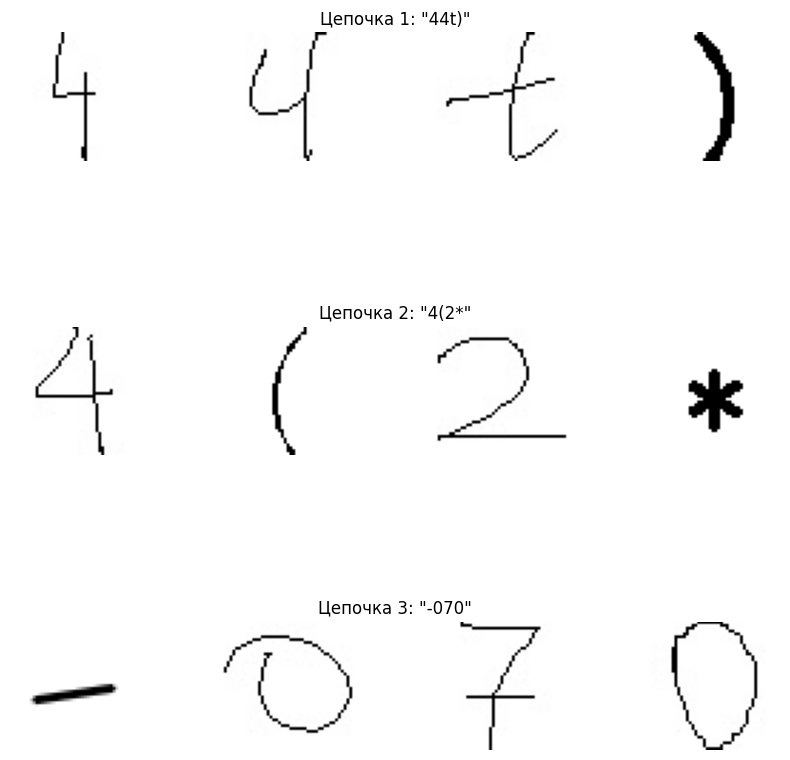

In [15]:

figure, axes = plt.subplots(NUM_SEQUENCES, 1, figsize=(8, 10))

for idx, (image_data, sequence_text) in enumerate(zip(final_combined_images, generated_sequences)):
    axes[idx].imshow(image_data, cmap='gray')
    axes[idx].set_title(f'Цепочка {idx+1}: "{sequence_text}"')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Обработка цепочки 1: '44t)'


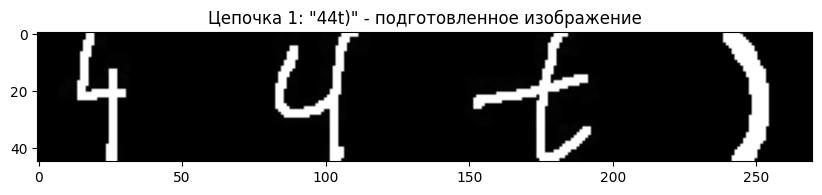

Размер бинарного изображения: (45, 270, 3)


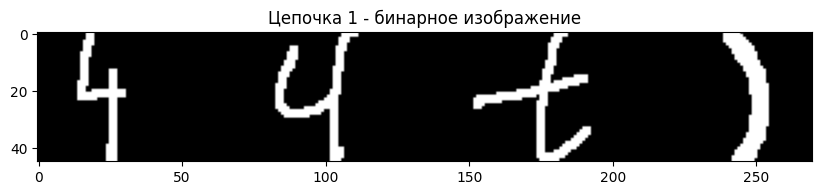

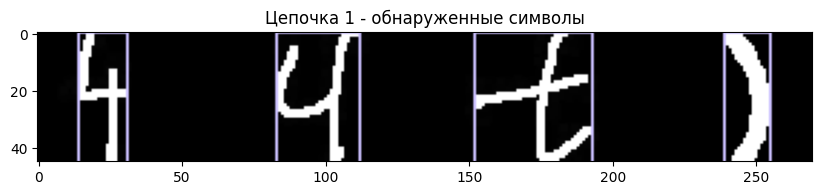

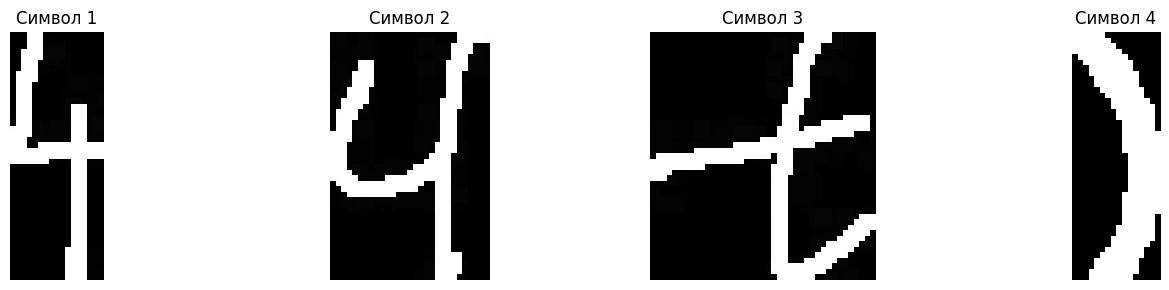

Цепочка 1 обработана. Найдено символов: 4

Обработка цепочки 2: '4(2*'


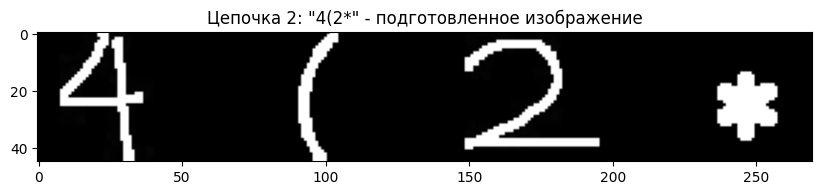

Размер бинарного изображения: (45, 270, 3)


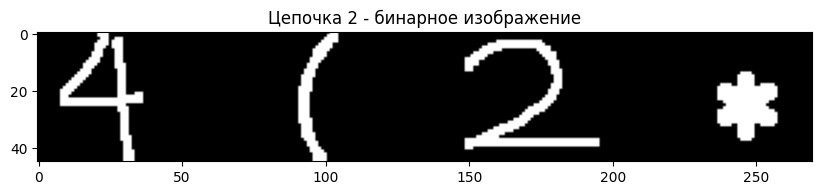

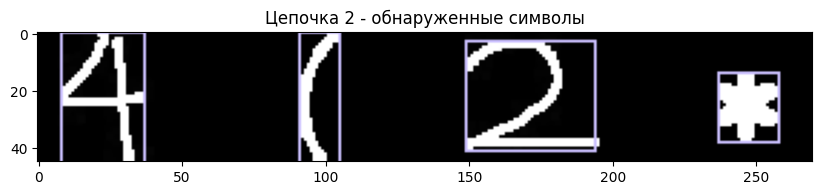

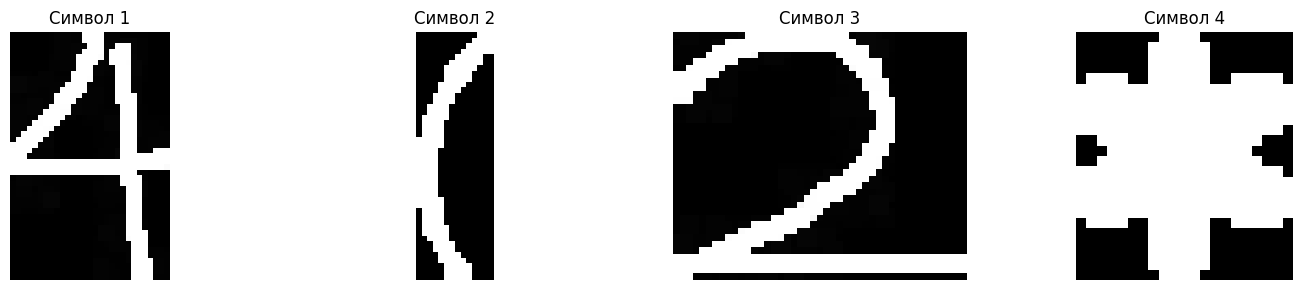

Цепочка 2 обработана. Найдено символов: 4

Обработка цепочки 3: '-070'


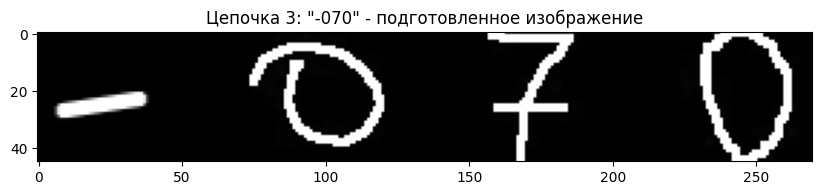

Размер бинарного изображения: (45, 270, 3)


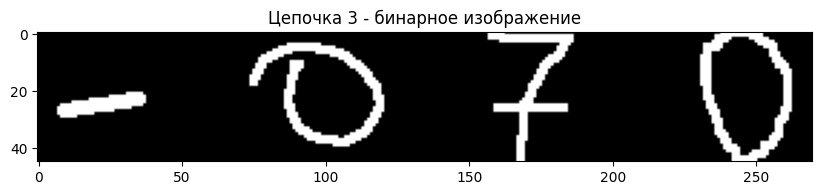

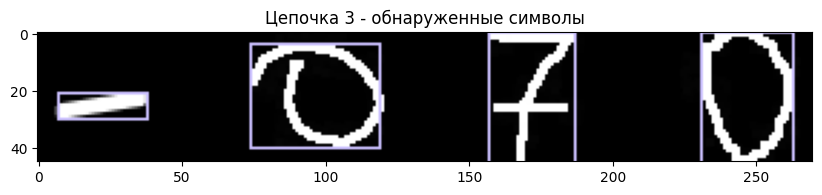

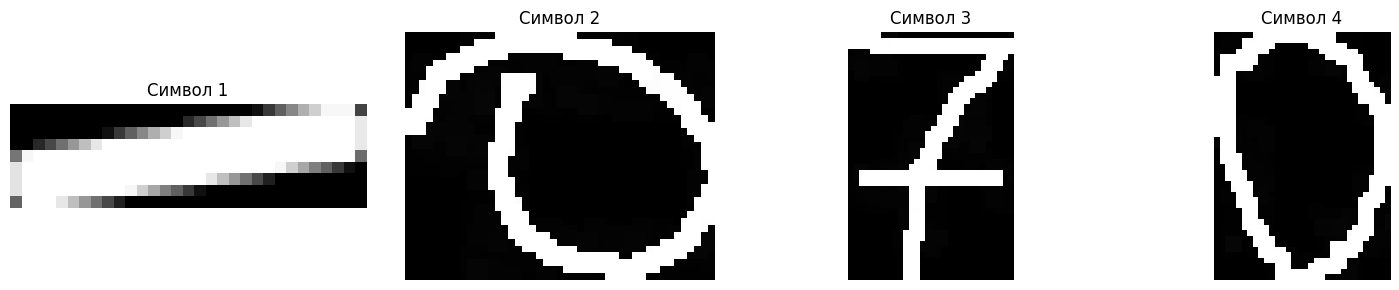

Цепочка 3 обработана. Найдено символов: 4


Все обработанные цепочки:
1. '44t)' - 4 символов
2. '4(2*' - 4 символов
3. '-070' - 4 символов


In [16]:
processed_sequences_data = []

for img_index, source_image in enumerate(final_combined_images):
    print(f"Обработка цепочки {img_index + 1}: '{generated_sequences[img_index]}'")
    
    #Предобработка
    processed_image = source_image.copy()
    structuring_element = np.ones((3,3), np.uint8)
    processed_image = cv2.erode(processed_image, structuring_element, iterations=1)
    processed_image = cv2.bitwise_not(processed_image)
    
    base_dimensions = processed_image.shape[0], processed_image.shape[1]
    base_image = np.zeros(base_dimensions, dtype=np.uint8)
    base_image[0:processed_image.shape[0], 0:processed_image.shape[1]] = processed_image
    base_image = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)
    
    rgb_image = base_image
    
    plt.figure(figsize=(10, 3))
    plt.imshow(rgb_image)
    plt.title(f'Цепочка {img_index + 1}: "{generated_sequences[img_index]}" - подготовленное изображение')
    plt.show()
    
    # Бинаризация
    threshold_value, binary_image = cv2.threshold(rgb_image, 127, 255, 0)
    print(f"Размер бинарного изображения: {binary_image.shape}")
    
    plt.figure(figsize=(10, 3))
    binary_image = np.uint8(binary_image)
    plt.imshow(binary_image)
    plt.title(f'Цепочка {img_index + 1} - бинарное изображение')
    plt.show()
    
    detected_contours, hierarchy = cv2.findContours(binary_image[:,:,0], 
                                                    cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_SIMPLE)
    character_bboxes = []
    detected_contours = sorted(detected_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    
    for current_contour in detected_contours:
        contour_area = cv2.contourArea(current_contour)
        x_pos, y_pos, width, height = cv2.boundingRect(current_contour)
        
        
        while (width > 45):
            width -= 1
        
        if width * height > 50:
            cv2.rectangle(rgb_image, (x_pos, y_pos), (x_pos+width, y_pos+height), 
                         (203,192,255), 1)
            character_bboxes.append([x_pos, y_pos, width, height])
    
    plt.figure(figsize=(10, 3))
    plt.imshow(rgb_image)
    plt.title(f'Цепочка {img_index + 1} - обнаруженные символы')
    plt.show()
    
    extracted_characters = []
    num_chars = len(character_bboxes)
    
    if num_chars > 0:
        fig, axes = plt.subplots(1, num_chars, figsize=(15, 3))
        if num_chars == 1:
            axes = [axes]
        
        for bbox_idx, bbox in enumerate(character_bboxes):
            x_pos, y_pos, width, height = bbox
            char_image = processed_image[y_pos:y_pos+height, x_pos:x_pos+width]
            char_data = char_image.copy()
            
            axes[bbox_idx].imshow(char_data, cmap="gray")
            axes[bbox_idx].set_title(f'Символ {bbox_idx+1}')
            axes[bbox_idx].axis('off')
            extracted_characters.append((x_pos, char_data))
        
        plt.tight_layout()
        plt.show()
    
    processed_sequences_data.append({
        'sequence_text': generated_sequences[img_index],
        'characters': extracted_characters
    })
    
    print(f"Цепочка {img_index + 1} обработана. Найдено символов: {len(extracted_characters)}\n")

print("\n" + "="*60)
print("Все обработанные цепочки:")
for seq_idx, sequence_info in enumerate(processed_sequences_data):
    print(f"{seq_idx+1}. '{sequence_info['sequence_text']}' - {len(sequence_info['characters'])} символов")
print("="*60)


In [17]:
character_set = ['0','1','2','3','4','5','6','7','8','9',
                'plus','minus','asterisk','t','X','y','w','h','lparen','rparen','comma']

#Загрузка обучающих данных
X_training, y_training = prepare_training_data(DATA_PATH, character_set)
print(f"Обучающая выборка: {len(X_training)} изображений\n")

#Обучение моделей с разными k
neighbor_counts = [1, 3, 5, 7]
knn_models = {}

for k_val in neighbor_counts:
    classifier = KNeighborsClassifier(n_neighbors=k_val)
    classifier.fit(X_training, y_training)
    knn_models[k_val] = classifier
    print(f"Модель KNN с k={k_val} обучена")

print(f"\n Всего обучено {len(knn_models)} моделей")


Обучающая выборка: 106736 изображений

Модель KNN с k=1 обучена
Модель KNN с k=3 обучена
Модель KNN с k=5 обучена
Модель KNN с k=7 обучена

 Всего обучено 4 моделей


In [18]:
print("Сравнение моделей с разными значениями k:")

performance_results = {}

for k_val, model in knn_models.items():
    print(f"Результат для k={k_val}")
    
    correct_predictions = 0
    total_characters = 0
    sequence_success = []
    
    for seq_idx, sequence_info in enumerate(processed_sequences_data):
        original_sequence = sequence_info['sequence_text']
        character_data = sequence_info['characters']
        
        print(f"\nЦепочка {seq_idx+1}:")
        print(f"Исходный текст: '{original_sequence}'")
        
        predicted_chars = []
        for char_idx, (x_coord, char_img) in enumerate(character_data):
            resized_char = cv2.resize(char_img, (45, 45))
            predicted_char = classify_character(model, resized_char)
            predicted_chars.append(predicted_char)
        
        predicted_sequence = ''.join(predicted_chars)
        print(f"Распознанный текст: '{predicted_sequence}'")
        
        # Подсчет точности
        correct_count = sum(1 for orig, pred in zip(original_sequence, predicted_sequence) 
                          if orig == pred)
        sequence_accuracy = correct_count / len(original_sequence)
        correct_predictions += correct_count
        total_characters += len(original_sequence)
        
        if original_sequence == predicted_sequence:
            print("Результат: Полное совпадение")
            sequence_success.append(1.0)
        else:
            print("Результат: Обнаружены ошибки")
            sequence_success.append(0.0)
            for pos, (orig_char, pred_char) in enumerate(zip(original_sequence, predicted_sequence)):
                if orig_char != pred_char:
                    print(f"Ошибка в позиции {pos+1}: ожидалось '{orig_char}', получено '{pred_char}'")
    
    overall_accuracy = correct_predictions / total_characters if total_characters > 0 else 0
    performance_results[k_val] = {
        'accuracy': overall_accuracy,
        'sequence_success_rate': np.mean(sequence_success),
        'correct_chars': correct_predictions,
        'total_chars': total_characters
    }
    
    print(f"Итоги для k={k_val}:")
    print(f"Правильно распознано: {correct_predictions}/{total_characters} символов")
    print(f"Точность: {overall_accuracy:.2%}")
    print(f"Полностью верных цепочек: {sum(sequence_success)}/{len(sequence_success)}")

print("Определение max значения k")

optimal_k = None
highest_accuracy = 0

for k_val, result in sorted(performance_results.items()):
    accuracy = result['accuracy']
    marker = "  - лучший" if accuracy > highest_accuracy else ""
    print(f"K={k_val}: Точность {accuracy:.2%} ({result['correct_chars']}/{result['total_chars']} символов){marker}")
    
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        optimal_k = k_val

print(f"Выводы: Наилучший результат при k={optimal_k} с точностью {highest_accuracy:.2%}")
print(f"Для данной задачи оптимально использовать k={optimal_k}")


Сравнение моделей с разными значениями k:
Результат для k=1

Цепочка 1:
Исходный текст: '44t)'
Распознанный текст: '41t3'
Результат: Обнаружены ошибки
Ошибка в позиции 2: ожидалось '4', получено '1'
Ошибка в позиции 4: ожидалось ')', получено '3'

Цепочка 2:
Исходный текст: '4(2*'
Распознанный текст: '4029'
Результат: Обнаружены ошибки
Ошибка в позиции 2: ожидалось '(', получено '0'
Ошибка в позиции 4: ожидалось '*', получено '9'

Цепочка 3:
Исходный текст: '-070'
Распознанный текст: 'w070'
Результат: Обнаружены ошибки
Ошибка в позиции 1: ожидалось '-', получено 'w'
Итоги для k=1:
Правильно распознано: 7/12 символов
Точность: 58.33%
Полностью верных цепочек: 0.0/3
Результат для k=3

Цепочка 1:
Исходный текст: '44t)'
Распознанный текст: '41t3'
Результат: Обнаружены ошибки
Ошибка в позиции 2: ожидалось '4', получено '1'
Ошибка в позиции 4: ожидалось ')', получено '3'

Цепочка 2:
Исходный текст: '4(2*'
Распознанный текст: '4029'
Результат: Обнаружены ошибки
Ошибка в позиции 2: ожидалось '

In [19]:
#Создание тестовых данных

import cv2
import numpy as np
import os

def create_test_character_image(char, size=(45, 45), font=cv2.FONT_HERSHEY_SIMPLEX):
    img = np.ones(size, dtype=np.uint8) * 255
    
    font_scale = 1.5
    thickness = 2
    
    (text_width, text_height), baseline = cv2.getTextSize(char, font, font_scale, thickness)
    
    x = (size[1] - text_width) // 2
    y = (size[0] + text_height) // 2
    
    cv2.putText(img, char, (x, y), font, font_scale, 0, thickness)
    
    return img

def create_test_dataset(data_path='./data', images_per_char=50):
    
    os.makedirs(data_path, exist_ok=True)
    
    characters = {
        '0': '0', '1': '1', '2': '2', '3': '3', '4': '4',
        '5': '5', '6': '6', '7': '7', '8': '8', '9': '9',
        'plus': '+', 'minus': '-', 'asterisk': '*',
        'lparen': '(', 'rparen': ')',
        'comma': ',',
        't': 't', 'X': 'X', 'y': 'y',
        'w': 'w', 'h': 'h'
    }
    
    print("Создание тестового датасета:")
    print(f"Папка: {data_path}")
    print(f"Изображений на символ: {images_per_char}")
    print("-" * 60)
    
    for char_name, display_char in characters.items():
        char_folder = os.path.join(data_path, char_name)
        os.makedirs(char_folder, exist_ok=True)
        
        for i in range(images_per_char):
            img = create_test_character_image(display_char)
            if i % 3 == 0:
                noise = np.random.normal(0, 10, img.shape).astype(np.int16)
                img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
            elif i % 3 == 1:
                angle = np.random.uniform(-10, 10)
                center = (img.shape[1] // 2, img.shape[0] // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), 
                                    borderValue=255)
            elif i % 3 == 2:
                if np.random.random() > 0.5:
                    kernel = np.ones((2,2), np.uint8)
                    img = cv2.erode(img, kernel, iterations=1)
                else:
                    kernel = np.ones((2,2), np.uint8)
                    img = cv2.dilate(img, kernel, iterations=1)
            
            img_path = os.path.join(char_folder, f'{char_name}_{i:03d}.png')
            cv2.imwrite(img_path, img)
        
        print(f"Создано {images_per_char} изображений для '{display_char}' в папке '{char_name}/'")
    
    print("-" * 60)
    print(f"Всего символов: {len(characters)}")
    print(f"Всего изображений: {len(characters) * images_per_char}")

create_test_dataset(data_path='./data', images_per_char=50)

Создание тестового датасета:
Папка: ./data
Изображений на символ: 50
------------------------------------------------------------
Создано 50 изображений для '0' в папке '0/'
Создано 50 изображений для '1' в папке '1/'
Создано 50 изображений для '2' в папке '2/'
Создано 50 изображений для '3' в папке '3/'
Создано 50 изображений для '4' в папке '4/'
Создано 50 изображений для '5' в папке '5/'
Создано 50 изображений для '6' в папке '6/'
Создано 50 изображений для '7' в папке '7/'
Создано 50 изображений для '8' в папке '8/'
Создано 50 изображений для '9' в папке '9/'
Создано 50 изображений для '+' в папке 'plus/'
Создано 50 изображений для '-' в папке 'minus/'
Создано 50 изображений для '*' в папке 'asterisk/'
Создано 50 изображений для '(' в папке 'lparen/'
Создано 50 изображений для ')' в папке 'rparen/'
Создано 50 изображений для ',' в папке 'comma/'
Создано 50 изображений для 't' в папке 't/'
Создано 50 изображений для 'X' в папке 'X/'
Создано 50 изображений для 'y' в папке 'y/'
Создан